# Classification of Iris Dataset Using Spark MLlib

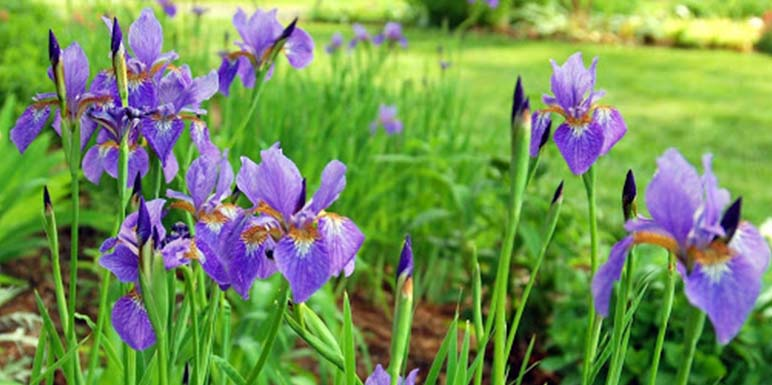

In [3]:
from IPython.display import Image
Image('images/iris.jpg', width =1000)

## Introduction

The Iris dataset is one of the most well-known datasets in the field of machine learning. It contains 150 samples of iris flowers, with each sample belonging to one of three species: Iris setosa, Iris versicolor, and Iris virginica. Each sample has four features: sepal length, sepal width, petal length, and petal width. This dataset is commonly used for classification tasks.



## Objectives

- Load the iris dataset into a Spark DataFrame.
- Split the dataset into training and testing sets.
- Use Random Forest as the classification algorithm from Spark MLlib.
- Employ techniques such as cross-validation and grid search to fine-tune the hyperparameters of the Random Forest.
- Evaluate the performance of the tuned model using relevant evaluation metrics (accuracy, precision, recall, F1-score).
- Use the tuned model to generate predictions on the testing data.
- Conduct a comparative analysis between the predicted labels and the actual labels to assess the model's performance.

## Methodology
### 1. Load the iris dataset
The Iris dataset was loaded into a Spark DataFrame. The dataset includes the following features for each flower sample:

- Sepal Length
- Sepal Width
- Petal Length
- Petal Width
- Label (Species)

In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Initialize Spark context and session
conf = SparkConf().setAppName("IrisClassification")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

# Load the Iris dataset
iris_data = spark.read.csv("file:///home/maria_dev/khairil/iris.csv", header=True, inferSchema=True)

# Rename the columns to match feature names
iris_data = iris_data.withColumnRenamed("Sepal.Length", "sepalLength")\
                     .withColumnRenamed("Sepal.Width", "sepalWidth")\
                     .withColumnRenamed("Petal.Length", "petalLength")\
                     .withColumnRenamed("Petal.Width", "petalWidth")\
                     .withColumnRenamed("Species", "label")

# Index labels (convert string labels to numeric)
indexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(iris_data)
iris_data = indexer.transform(iris_data)

# Verify the label indexing
label_to_index = {row['label']: row['indexedLabel'] for row in iris_data.select("label", "indexedLabel").distinct().collect()}
print("Label to Index Mapping:", label_to_index)

# Assemble features into a feature vector
assembler = VectorAssembler(inputCols=["sepalLength", "sepalWidth", "petalLength", "petalWidth"], outputCol="features")
iris_data = assembler.transform(iris_data)

# Show the first 5 rows
iris_data.show(5)


Below is a snapshot of the dataset:

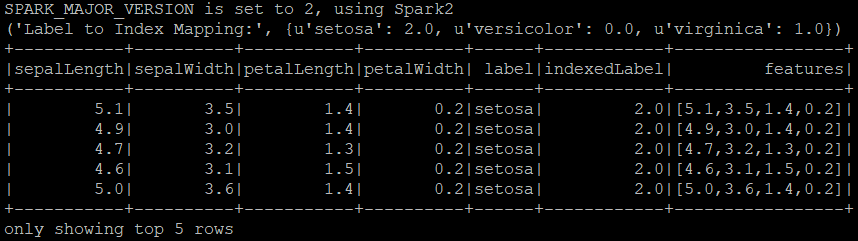

In [6]:
Image('images/ast3_show.png', width =800)

The dataset was then split into training and testing sets to facilitate model evaluation.



### 2. Random Forest

Random Forest was chosen as the classification algorithm due to its robustness and effectiveness in handling multi-class classification problems. Random Forest operates by constructing multiple decision trees during training and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

To improve the performance of the Random Forest model, techniques such as cross-validation and grid search were employed to fine-tune the hyperparameters. This involved evaluating various combinations of parameters to identify the best-performing model configuration.

In [ ]:
# Print schema
iris_data.printSchema()

# Split the dataset into training and testing sets
train_data, test_data = iris_data.randomSplit([0.8, 0.2], seed=42)

# Random Forest is selected as a classification algorithm
random_forest = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features")

# Define a grid of hyperparameters to search over
param_grid = ParamGridBuilder()\
    .addGrid(random_forest.numTrees, [10, 20, 30])\
    .addGrid(random_forest.maxDepth, [5, 10, 15])\
    .build()

# Use cross-validation to tune hyperparameters
crossval = CrossValidator(estimator=random_forest,
                          estimatorParamMaps=param_grid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="indexedLabel", metricName="accuracy"),
                          numFolds=5)

# Fit the model on the training data
cv_model = crossval.fit(train_data)


### 3. Model Evaluation

The tuned model was evaluated using the following metrics:

- Accuracy
- Precision
- Recall
- F1-score

These metrics provide a comprehensive understanding of the model's performance.

### 4. Predictions and Comparative Analysis

The tuned model was used to generate predictions on the testing data. A comparative analysis was then conducted to assess the alignment between the predicted labels and the actual labels.



In [ ]:
# Evaluate the model on the test data
predictions = cv_model.transform(test_data)

# Evaluate the performance of the model
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-Score: {:.2f}".format(f1))

# Collect predictions to visualize
predictions.select("indexedLabel", "prediction").groupBy("indexedLabel", "prediction").count().show()


## Findings and Discussion

Below is the confusion matrix summarizing the model's performance:

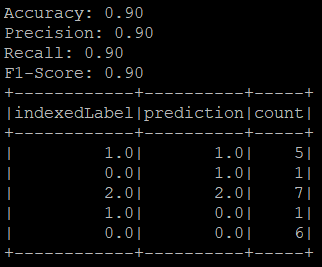

In [9]:
Image('images/ast3_table.png', width =300)

### Comparative Analysis

To assess the performance of the tuned Random Forest model, a comparative analysis between the predicted labels and the actual labels was conducted using a confusion matrix and evaluation metrics.

**Confusion Matrix:**

The confusion matrix showed the following counts:

- Correctly predicted Setosa: 5
- Correctly predicted Versicolor: 7
- Correctly predicted Virginica: 6
- Misclassified Versicolor as Setosa: 1
- Misclassified Setosa as Versicolor: 1
- Misclassified Virginica as Versicolor: 1

**Evaluation Metrics:**

The model achieved high performance across all metrics:

- Accuracy: 0.90
- Precision: 0.90
- Recall: 0.90
- F1-score: 0.90

The confusion matrix and metrics indicate that the Random Forest classifier performed well, with high accuracy and minimal misclassifications. This confirms the model's effectiveness in classifying the iris dataset and demonstrates its robustness in handling multi-class classification tasks.

## Conclusion

The analysis demonstrated that the Random Forest classifier, when fine-tuned using cross-validation and grid search, is highly effective in classifying the iris dataset. The model achieved high scores across all evaluation metrics, confirming its robustness. This study highlights the importance of hyperparameter tuning and the potential of Random Forest in handling classification tasks with multiple classes.

Further improvements could include experimenting with other classification algorithms, increasing the dataset size, or incorporating additional features to potentially enhance model performance.